# Test: divergence in HC3N structure

We analyse if the divergence of the velocity gradients $\nabla \cdot \nabla$v can give us a clue if infall is hiding within all the outflow activity in HC3N. The velocity gradients will tell us how the mass accelerates, the divergence will indicate any changes in this behavior

For this, first we need the velocity gradient of HC3N. We have a main cluster where we can do the analysis first.

We will have to do this with N2Hp as well.

In [1]:
import numpy as np
import os
import scipy.linalg # for initial guesses
from scipy.optimize import curve_fit # to obtain the fit with errors
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.wcs import WCS
%matplotlib widget

In [2]:
# HC3N1gfile = '../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_filtered_QA.fits'
HC3N1gfile = '../clustering/cluster1_HC3N_w0.5_r2.fits' # this is all the 1 gaussian component fit plus the closest 2 and 3 gaussians to fill the gaps

# to save
velgradbasefile = 'vel_grad_{}_HC3N.fits'
velgradxfile = velgradbasefile.format('x')
e_velgradxfile = velgradbasefile.format('x_unc')
velgradyfile = velgradbasefile.format('y')
e_velgradyfile = velgradbasefile.format('y_unc')
velgradamplfile = velgradbasefile.format('magnitude')
e_velgradamplfile = velgradbasefile.format('magnitude_unc')
velgradvclfile = velgradbasefile.format('vc')
e_velgradvclfile = velgradbasefile.format('vc_unc')

overwrite = True

## Calculating velocity gradients


In principle, we need to sample at least 2 beams, so that the values are uncorrelated


In [3]:
# load the velocity and its associated uncertainty
params, parheader = fits.getdata(HC3N1gfile, header=True)
velfield = params[1] # km/s
velerror = params[4]
# load the sky WCS
wcssky = WCS(parheader).celestial
# load the beam size
beammaj, beammin, bpa = (parheader['BMAJ'], parheader['BMIN'], parheader['BPA']) * u.deg
pixsize = np.abs(parheader['CDELT2']) * u.deg
nbeams = 2
equivradius = np.sqrt(beammaj * beammin / (4 * np.log(2)))  #equivalence with solid angle of beam in radius form
equivradiuspix = (equivradius / pixsize).value # radius in pixels
sampleradiuspix = int(np.round(nbeams* equivradiuspix, 0))
minarea_calc = (np.pi * sampleradiuspix ** 2) / 3 #at least a third of pixels in the area must be available
print("Running program for a gradient with a width of {} beams".format(nbeams))
pixsize_pc = (((pixsize.to(u.arcsec) * 302).value) * u.au).to(u.pc).value # parsec per pixel
pixsize_au = (((pixsize.to(u.arcsec) * 302).value) * u.au).value # au per pixel
print("Beam size: {0} x {1}".format(np.round(beammaj.to(u.arcsec), 1), np.round(beammin.to(u.arcsec), 1)))
print("The equivalent radius is {0} pixels, the sample radius is {1}, needs a minimum of {2} pixels".format(np.round(equivradiuspix, 1), np.round(sampleradiuspix, 1), np.round(minarea_calc, 1)))

# tolerance parameter for the linear algebra
epsilon = 1e-3

Running program for a gradient with a width of 2 beams
Beam size: 4.9 arcsec x 4.7 arcsec
The equivalent radius is 3.7 pixels, the sample radius is 7, needs a minimum of 51.3 pixels


In [4]:
def plane(X, A, B, vc):
    xpos, ypos = X
    return A*xpos + B*ypos + vc

def gradient(scalarfield, e_scalarfield, radius, minarea, pixunit, eps=1e-3):
    filled_indices = np.where(~np.isnan(scalarfield))
    gx = np.zeros(np.shape(scalarfield)) * np.nan
    e_gx = np.zeros(np.shape(scalarfield)) * np.nan
    gy = np.zeros(np.shape(scalarfield)) * np.nan
    e_gy = np.zeros(np.shape(scalarfield)) * np.nan
    constant = np.zeros(np.shape(scalarfield)) * np.nan
    e_constant = np.zeros(np.shape(scalarfield)) * np.nan
    magnitude = np.zeros(np.shape(scalarfield)) * np.nan
    e_magnitude = np.zeros(np.shape(scalarfield)) * np.nan
    jumped = 0
    for y, x in zip(filled_indices[0], filled_indices[1]):
        sampleregion = scalarfield[y-radius:y+radius+1, x-radius:x+radius+1]
        sampleerror = e_scalarfield[y-radius:y+radius+1, x-radius:x+radius+1]
        X,Y = np.meshgrid(np.arange(-radius, radius+1, 1), np.arange(-radius, radius+1, 1))
        if (np.shape(sampleregion)[0] != np.shape(sampleregion)[1]): continue
        index_sampleregion_filter = np.where(~np.isnan(sampleregion))
        if len(index_sampleregion_filter[0]) < minarea:
            jumped+=1
            # print('jumped {} {}'.format(x, y), index_sampleregion_filter[0])
            continue
        else:
            # we define the X and Y positions
            # we need to get the gradient in km/s/pc
            X_pc = X[index_sampleregion_filter] * pixunit
            Y_pc = Y[index_sampleregion_filter] * pixunit
            sampleregion_filtered = sampleregion[index_sampleregion_filter]
            sampleerror_filtered = sampleerror[index_sampleregion_filter]
            data_sample = np.transpose([X_pc, Y_pc, sampleregion_filtered])

            # we obtain the initial guesses
            A = np.c_[data_sample[:,0],data_sample[:,1], np.ones(data_sample.shape[0])] # design matrix X, Y, constants
            C,_,_,_ = scipy.linalg.lstsq(A, data_sample[:,2])
            if np.abs(C[0])< eps or np.abs(C[1])< eps: continue
            A0 = C[0]
            B0 = C[1]
            vc0 = C[2]
            # now we fit with the error map as well
            popt, pcov = curve_fit(plane, (X_pc, Y_pc), sampleregion_filtered, p0=[A0, B0, vc0], sigma=sampleerror_filtered, absolute_sigma=True) 
            #values
            gx[y, x] = popt[0]
            gy[y, x] = popt[1]
            constant[y, x] = popt[2]
            magnitude[y, x] = np.sqrt(popt[1]**2 + popt[0]**2)
            #uncertainties
            perr = np.sqrt(np.diag(pcov))
            e_gx[y, x] = perr[0]
            e_gy[y, x] = perr[1]
            e_constant[y, x] = perr[2]
            e_magnitude[y, x] = np.sqrt(perr[0]**2 + perr[1]**2)
            
    values = [gx, gy, constant, magnitude]
    errors = [e_gx, e_gy, e_constant, e_magnitude]
    return values, errors, jumped

In [5]:
if not os.path.exists(velgradxfile) or not os.path.exists(velgradxfile) or overwrite:
    values_grad, errors_grad, jumped_grad = gradient(velfield, velerror, sampleradiuspix, minarea_calc, pixsize_pc, eps=1e-3)
    gradheader = wcssky.to_header()
    gradheader['BUNIT'] = 'km s-1 pc-1'
    velheader = wcssky.to_header()
    velheader['BUNIT'] = 'km s-1'
    nablax_map = values_grad[0]
    nablay_map = values_grad[1]
    vc_map = values_grad[2]
    absnabla_map = values_grad[3]
    e_nablax_map = errors_grad[0]
    e_nablay_map = errors_grad[1]
    e_vc_map = errors_grad[2]
    e_absnabla_map = errors_grad[3]
    fits.writeto(velgradxfile, nablax_map, gradheader, overwrite=True)
    fits.writeto(e_velgradxfile, e_nablax_map, gradheader, overwrite=True)
    fits.writeto(velgradyfile, nablay_map, gradheader, overwrite=True)
    fits.writeto(e_velgradyfile, e_nablay_map, gradheader, overwrite=True)
    fits.writeto(velgradvclfile, vc_map, velheader, overwrite=True)
    fits.writeto(e_velgradvclfile, e_vc_map, velheader, overwrite=True)
    fits.writeto(velgradamplfile, absnabla_map, gradheader, overwrite=True)
    fits.writeto(e_velgradamplfile, e_absnabla_map, gradheader, overwrite=True)
    print('The program jumped '+str(jumped_grad)+ ' pixels that had less than 1/3 available neighbors')
    
else:
    nablax_map, gradheader = fits.getdata(velgradxfile, header=True)
    e_nablax_map, gradheader = fits.getdata(e_velgradxfile, header=True)
    nablay_map = fits.getdata(velgradyfile)
    e_nablay_map = fits.getdata(e_velgradyfile)
    vc_map, velheader = fits.getdata(velgradvclfile, header=True)
    e_vc_map = fits.getdata(e_velgradvclfile)
    absnabla_map = fits.getdata(velgradamplfile)
    e_absnabla_map = fits.getdata(e_velgradamplfile)

The program jumped 316 pixels that had less than 1/3 available neighbors


Now that we calculated the gradients, lets plot them!


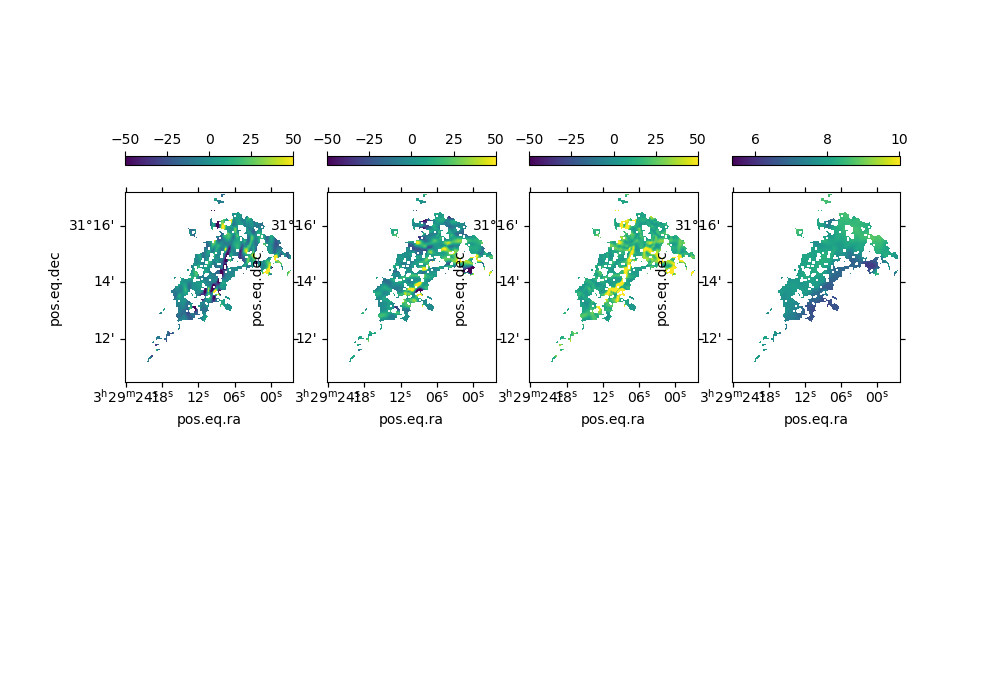

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, subplot_kw={'projection': wcssky}, figsize=(10,7))

im = ax[0].imshow(nablax_map, vmin=-50, vmax=50)
fig.colorbar(im, ax=ax[0], location='top')
im2 = ax[1].imshow(nablay_map, vmin=-50, vmax=50)
fig.colorbar(im2, ax=ax[1], location='top')
im3 = ax[2].imshow(absnabla_map, vmin=-50, vmax=50)
fig.colorbar(im3, ax=ax[2], location='top')
im4 = ax[3].imshow(vc_map)
fig.colorbar(im4, ax=ax[3], location='top')

The values look right, normally between -10 and 10 km/s/pc. 

## Divergence of velocity gradient

Now that we have the components of the velocity gradients, we can calculate the divergence.

Actually, there is a more straightforward way... the divergence of a gradient is called a Laplacian (of a scalar field). So, if we find an operator that calculates the sum of the second derivatives of our field directly, we do not need to calculate the divergence.

We test the Laplacian filter with numpy convolution. We would like to compare this to a brute force approach.

The brute force approach is to calculate the divergence of the gradient, by using the same function as what we used to calculate the gradients previously.

\begin{equation}
\nabla \cdot \vec{\nabla v} = \frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2}
\end{equation}

So, we take the maps $\vec{\nabla v}_x$ and $\vec{\nabla v}_y$, we do the gradients on those, and just take the map for the x direction for $\nabla(\vec{\nabla v}_x)$ and the y direction for $\nabla(\vec{\nabla v}_y)$ and add them up

In [14]:
divfile_brute = 'laplacian_velfield_diag_brute_pc.fits'
e_divfile_brute = 'laplacian_velfield_diag_brute_pc_unc.fits'
divfile_brute_magnitude = 'laplacian_velfield_diag_brute_pc_abs.fits'
overwrite = False

In [17]:
if not os.path.exists(divfile_brute) or overwrite:
    values_divx, errors_divx, jumped_divx = gradient(nablax_map, e_nablax_map, sampleradiuspix, minarea_calc, pixsize_pc, eps=1e-3)
    values_divy, errors_divy, jumped_divy = gradient(nablay_map, e_nablay_map, sampleradiuspix, minarea_calc, pixsize_pc, eps=1e-3)
    vxx = values_divx[0]
    vyy = values_divy[1]
    e_vxx = errors_divx[0]
    e_vyy = errors_divy[1]
    laplacian_map = vxx + vyy
    e_laplacian_map = e_vxx + e_vyy
    divheader = wcssky.to_header()
    divheader['BUNIT'] = 'km s-1 pc-2'
    fits.writeto(divfile_brute, laplacian_map, divheader, overwrite=True)
    fits.writeto(e_divfile_brute, e_laplacian_map, divheader, overwrite=True)
else:
    laplacian_map, divheader = fits.getdata(divfile_brute, header=True)
    e_laplacian_map = fits.getdata(e_divfile_brute)
if not os.path.exists(divfile_brute_magnitude) or overwrite:
    abs_laplacian_map = np.abs(laplacian_map)
    fits.writeto(divfile_brute_magnitude, abs_laplacian_map, divheader, overwrite=True)
else:
    abs_laplace_map = fits.getdata(divfile_brute_magnitude)

Using the laplacian operator did not work when convolved, and has the drawback that we cannot obtain uncertainties from it

In [9]:
# from astropy.convolution import convolve, Gaussian2DKernel
# from scipy.ndimage import convolve
# from scipy.signal import convolve2d
# divfile_iso = 'laplacian_velfield_diag_scipy_pc.fits'

In [10]:
# instead of using the default scipy laplacian operator
# 0 1 0
# 1 -4 1
# # 0 1 0

# # also, as we need to take independant areas, we need to expand this kernel to the size of two beams (just as we did for the gradient)


# if not os.path.exists(divfile_iso) or overwrite:
#     kernel_laplace = np.array([[0,1,0], [1,-4,1], [0,1,0]])
#     kernel_gaussian = Gaussian2DKernel(x_stddev=sampleradiuspix, y_stddev=sampleradiuspix)
#     kernel_combined = convolve2d(kernel_laplace, kernel_gaussian, mode='full', boundary='fill') 
#     divergence_iso = convolve(velfield, kernel_laplace, mode='constant') # convolution is associative
#     divergence_iso_pc = divergence_iso / (pixsize_pc**2) # km/s/au2
#     divheader = wcssky.to_header()
#     divheader['BUNIT'] = 'km s-1 pc-2'
#     fits.writeto(divfile_iso, divergence_iso_pc, divheader, overwrite=True)
# else:
#     divergence_iso_pc, divheader = fits.getdata(divfile_iso, divheader)